## Introduction

This notebook intends to analyse the videos of Gallium crystallizing on a glass surface after contact with a crystal seed, obtained with the microscope. First the video is splitted frame by frame. Then the image is porcessed using morphological operations in order to extract the shape of the crystal growing from the bulk. The area of this crystal is recorded, it is possible to observe the growth rate.
As the gallium is entrapped between two planes, the problem is considered in 2D. 

### Initialization
In this section the crystallization video is saved in an array of images, and the metadata such as framerate, size of the frames, etc... is collected.

In [24]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import skvideo.io as skv
from PIL import Image
import matplotlib.widgets as widgets
import obspy.signal.filter as filt
from scipy import ndimage
from skimage import color
from skimage import io
import os
%matplotlib notebook
mapc = 'copper'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [25]:
#The following function enables the opening of a pop up window that lets
#the user choose a file from the computer 

def openfile_dialog():
    from PyQt5 import QtGui
    from PyQt5 import QtGui, QtWidgets
    app = QtWidgets.QApplication([dir])
    fname = QtWidgets.QFileDialog.getOpenFileName(None, directory=os.getcwd(), caption = "Select a video file...",
                                                  filter="All files (*)")
    return fname[0]

In [26]:
#Selection of the video file
file = openfile_dialog()
print(file)

D:/Max_Planck/12.09/lighter_2.avi


In [29]:
#Acquisition of the metadata of the video for following analysis
metadata = skv.ffprobe(file)
fps = eval(metadata["video"]["@r_frame_rate"])
bit_rate = eval(metadata["video"]["@bit_rate"])
N = eval(metadata["video"]["@nb_frames"])
width = eval(metadata["video"]["@coded_width"])
height = eval(metadata["video"]["@coded_height"])

In [30]:
scale = 5 #microscope ojective scale
if scale == 5:
    pix = 936*936
elif scale == 2.5:
    pix = 468*468

In [31]:
#Read the video and save it as an array of the following shape
vid = skv.vread(file, num_frames=N)
print(vid.shape) #nb of frames, and size of each frame

(2701, 2048, 2048, 3)


## Image analysis

The content of the video has to be first analysed in order to create a function "extract_crystal" that will modify each frame in order to extract the crystal and measure the area of Gallium that has crystallized. To build this function, the frame where the crystallization starts is first manually identified, it will be substracted from all the following frames in order to make the crystal appear in contrast. 

<IPython.core.display.Javascript object>


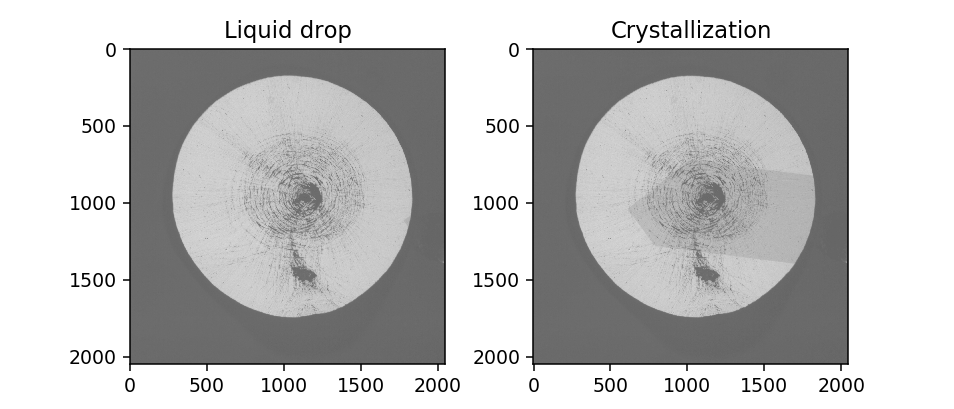

In [32]:
ini = 150
back = (vid[ini])#.reshape(width, height)) #Beginning of the crystallization
front = (vid[500])#.reshape(width, height)) #Image that will be used to build the function extract_crystal


plt.figure(figsize = (7, 3))
plt.subplot(121)
plt.title('Liquid drop')

plt.imshow(back, cmap = 'gray')
plt.subplot(122)
plt.title('Crystallization')
plt.imshow(front, cmap = 'gray')


#### Substraction of the background

<IPython.core.display.Javascript object>


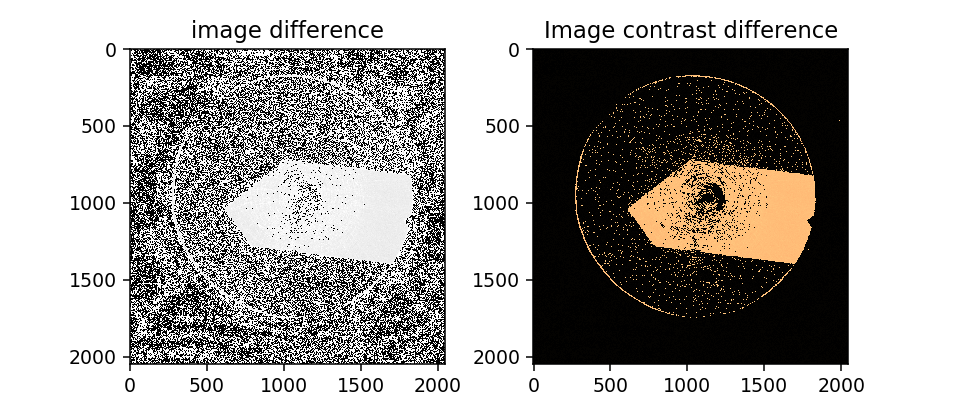

In [33]:
import skimage
s = front-back #substract crystallizing drop with liquid drop
plt.figure(figsize = (7, 3))
plt.subplot(1, 2 ,1)
plt.imshow(s)
plt.title('image difference')

plt.subplot(1,2,2)
s = skimage.color.rgb2hsv(s)
cont= np.mod(s, 0.983) #RGB to HSV conversion 
#The modulus is necessary because the image difference can be positive or negative
#Which converts into a high difference although the pixel values are close

#(change of image representation from colors to hue, saturation and contrast)
plt.imshow(cont[:,:,2], cmap = mapc) #This channel corresponds to the contrast
plt.title('Image contrast difference')
plt.show()

#### Binarization

<IPython.core.display.Javascript object>


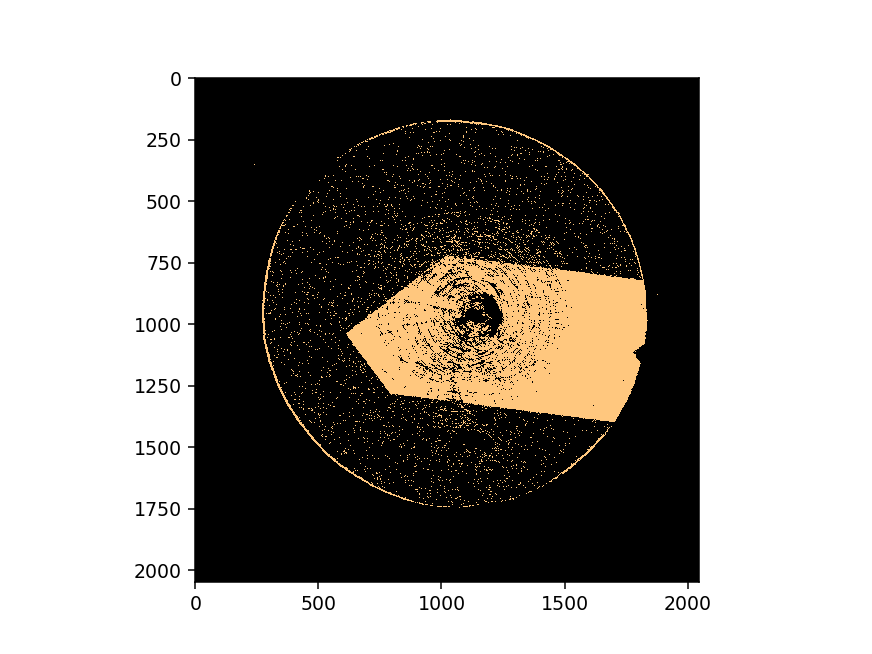

In [34]:
from skimage import data
from skimage.filters import threshold_minimum, threshold_otsu, try_all_threshold #IMPORT FILTER
plt.figure()
thresh = threshold_minimum(cont[:,:,2])
binary = cont[:,:,2] > thresh
plt.imshow(binary, cmap = mapc)
#fig, ax = try_all_threshold(cont[:,:,2], figsize=(10, 8), verbose=False)


#### Extraction of the crystal: watershed

This method uses a watershed process. The best way to understand this process is to think of the image as a landscape: black pixels represent the ground, and white pixels are cavities in the ground. We want to extract the cristal in the image, which is the biggest cavity in the ground.


In the end, we want to extract only this area, so the first step is to separate this area from all the other isolated cavities. We need to measure the distance of the center of the cavities to their edge to get an idea of their surface. To do this, we will fill up all the cavities step by step, starting from the edges, to level them up to the ground. *At every step, the distance of the edges of the cavities to their center is reduced by 1 pixel (dilation operation).* When a cavity is completly filled, the number of layers it took to fill it corresponds to its radius. That way, each isolated cavity can be identified and its size is roughly known. 


We select the biggest cavity, which corresponds to our crystal. Then, we put a source of water in the center of this cavity and let it fill the cavity from the bottom, until the water reaches the level of the ground. This water has exactely the shape of the crystal, and the amount of water added corresponds to the size of the crystal. This is a watershed process.  

<IPython.core.display.Javascript object>


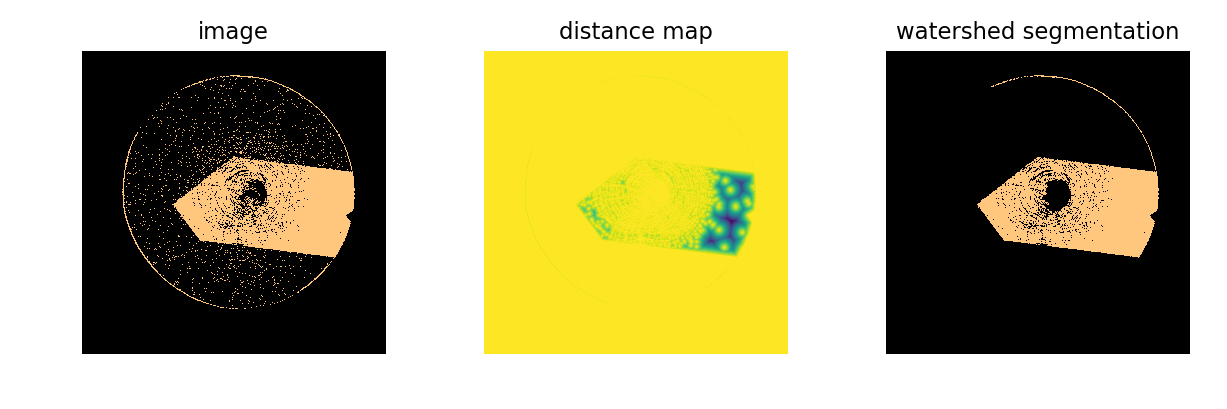

In [35]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure

image = binary
# Generate the markers as local maxima of the distance
# to the background
distance = ndimage.distance_transform_edt(binary)
local_maxi = distance > 30
#local_maxi = peak_local_max(
#    distance, indices=False, footprint=np.ones((30, 30)), labels=image)
markers = measure.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)
ws = labels_ws>0

plt.figure(figsize = (9, 3))
plt.subplot(131)
plt.imshow(image, cmap=mapc, interpolation='nearest')
plt.axis('off')
plt.title('image')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.title('distance map')
plt.subplot(133)
plt.imshow(ws, cmap=mapc, interpolation='nearest')
plt.axis('off')
plt.title('watershed segmentation')


plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


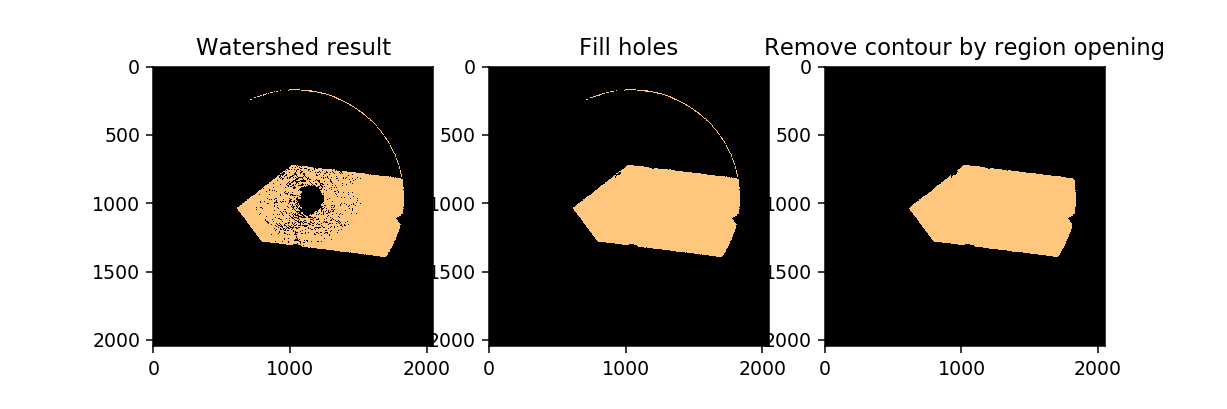

Text(0.5,1,'Remove contour by region opening')

In [36]:
import scipy.ndimage.morphology as morpho

plt.figure(figsize = (9, 3))
plt.subplot(1, 3, 1)
plt.imshow(ws, cmap = mapc)
plt.title('Watershed result')

plt.subplot(1, 3, 2)
holes = morpho.binary_fill_holes(ws)
plt.imshow(holes, cmap = mapc)
plt.title('Fill holes')

plt.subplot(1, 3, 3)
opening = morpho.binary_opening(holes, structure=np.ones((9,9)))
plt.imshow(opening, cmap =  mapc)
plt.title('Remove contour by region opening')

### Image processing function extract_crystal

Compilation of all the previous operations

<IPython.core.display.Javascript object>


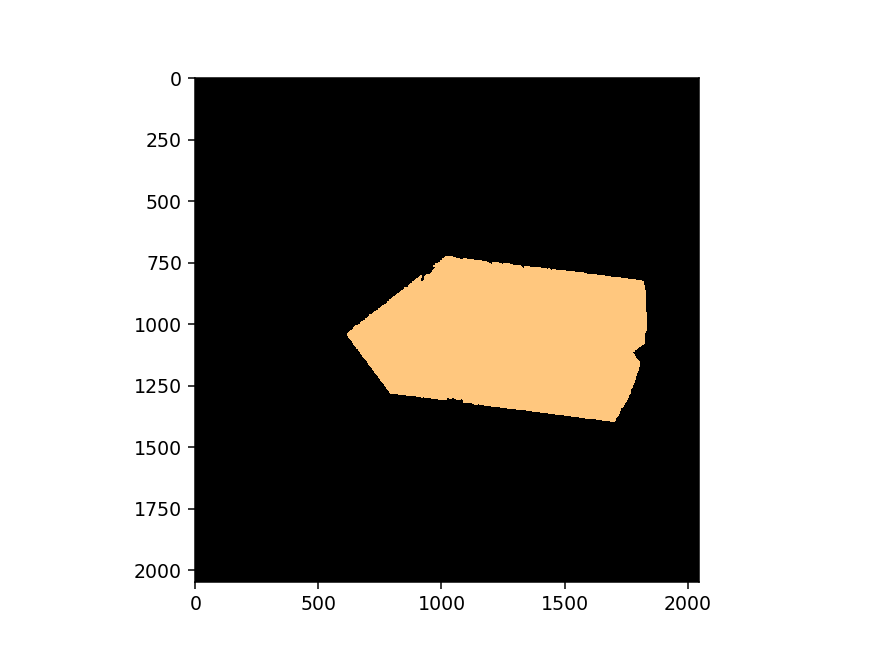

In [37]:
import scipy.ndimage

def extract_crystal(front, back, i):
    '''
    This function extracts the crystal shape given the image crystallized and the image before crystallization.
    It performs a pipeline of morphological operations on the image. For more informations on morphology  analysis: 
    http://scikit-image.org/docs/dev/api/skimage.morphology.html 
    
    input: front [np.array]: image of drop crystallizing
           back [np.array]: image of drop before crystallization
           i [float or int]: parameter for the watershed distance threshold
           
    output: [binary np.array]: image of the crystal extracted
    '''
    s = front-back #difference from liquid state
    cont= np.mod(skimage.color.rgb2hsv(s), 0.983)[:,:,2] #contrast image filtered
    thresh = threshold_otsu(cont)
    binary = cont > thresh #make binary
    distance = ndimage.distance_transform_edt(binary)
    local_maxi = distance > i
    markers = measure.label(local_maxi)
    ws = watershed(-distance, markers, mask=binary)>0
    out = morpho.binary_fill_holes(ws)
    #to fill the wholes of the wrinkles
    out = morpho.binary_opening(out, structure=np.ones((9,9))) 
    #to remove the contour of the drop that appears due to phase change expansion

    return out

out = extract_crystal(vid[500], vid[ini], 20)
plt.figure()
plt.imshow(out, cmap = mapc)

In [43]:
import scipy.ndimage.morphology
import copy
from scipy.ndimage.morphology import binary_erosion


def contour(Im):
    '''
    Draws the contour of the drop and the crystal on the image.
    Input: Im [np.array]: image to contour
    Output: Imin [np.array]: image countoured
            S [float]: surface of the crystal in mm^2
    '''
    background = scipy.ndimage.morphology.grey_opening(vid[ini], size = (800,800, 3)) #backgroug of the image

    Imin = np.copy(Im) - background #remove background

    r = Imin[:,:,0] #RGB split channels
    g = Imin[:,:,1]
    b = Imin[:,:,2]
    
    r +=50  #enhance contrast
    g +=50
    b +=50
    
    im = Imin
    

    #Crystal extraction
    Cry = extract_crystal(Im, vid[ini], 20)
    S = np.sum(Cry)/pix
    Cry = scipy.ndimage.morphology.binary_opening(Cry, structure=np.ones((9,9)))
    contcry = Cry^binary_erosion(Cry, iterations = 5)
    
    
    g[Cry] += 20 #Crystal in blue
    b[Cry] += 40

    #r[contcry] = 0  #uncomment to draw contour of the crystal 
    #g[contcry] = 0
    #b[contcry] = 0
    
        #Countour of the drop
    thresh = threshold_minimum(im[:,:,2])
    im = im[:,:,2] > thresh
    im =  morpho.binary_fill_holes(im)
    im = im^binary_erosion(im, iterations = 12)
    im = binary_erosion(im, iterations = 1)
    
    g[im] = 255 #Contour in white
    r[im] = 255
    b[im] = 255
    
    

    return Imin, S

<IPython.core.display.Javascript object>


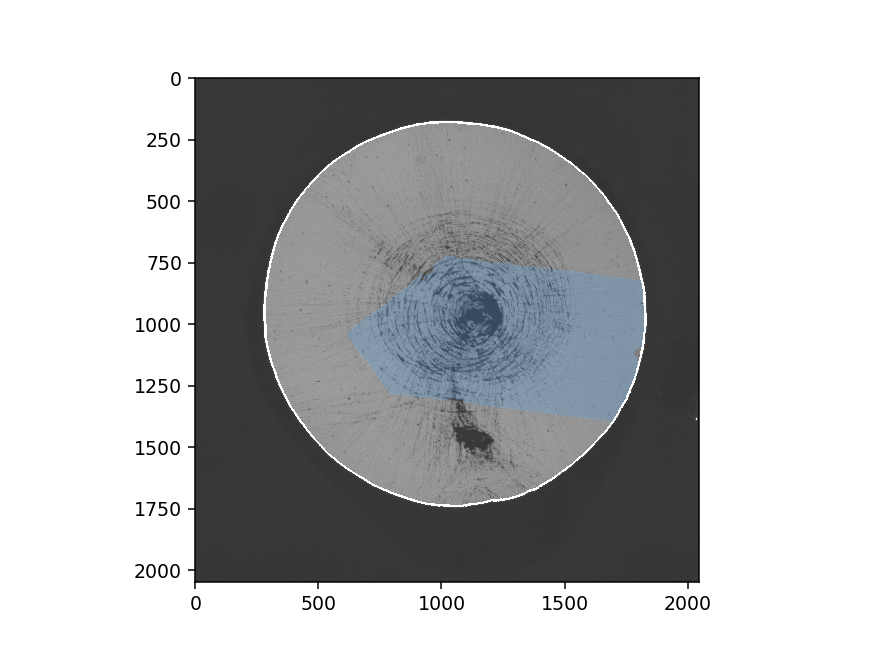

In [44]:
plt.figure()
Im, surf = contour(np.copy(vid[500]))
plt.imshow(Im)

### Crystal growth and overlay

<IPython.core.display.Javascript object>


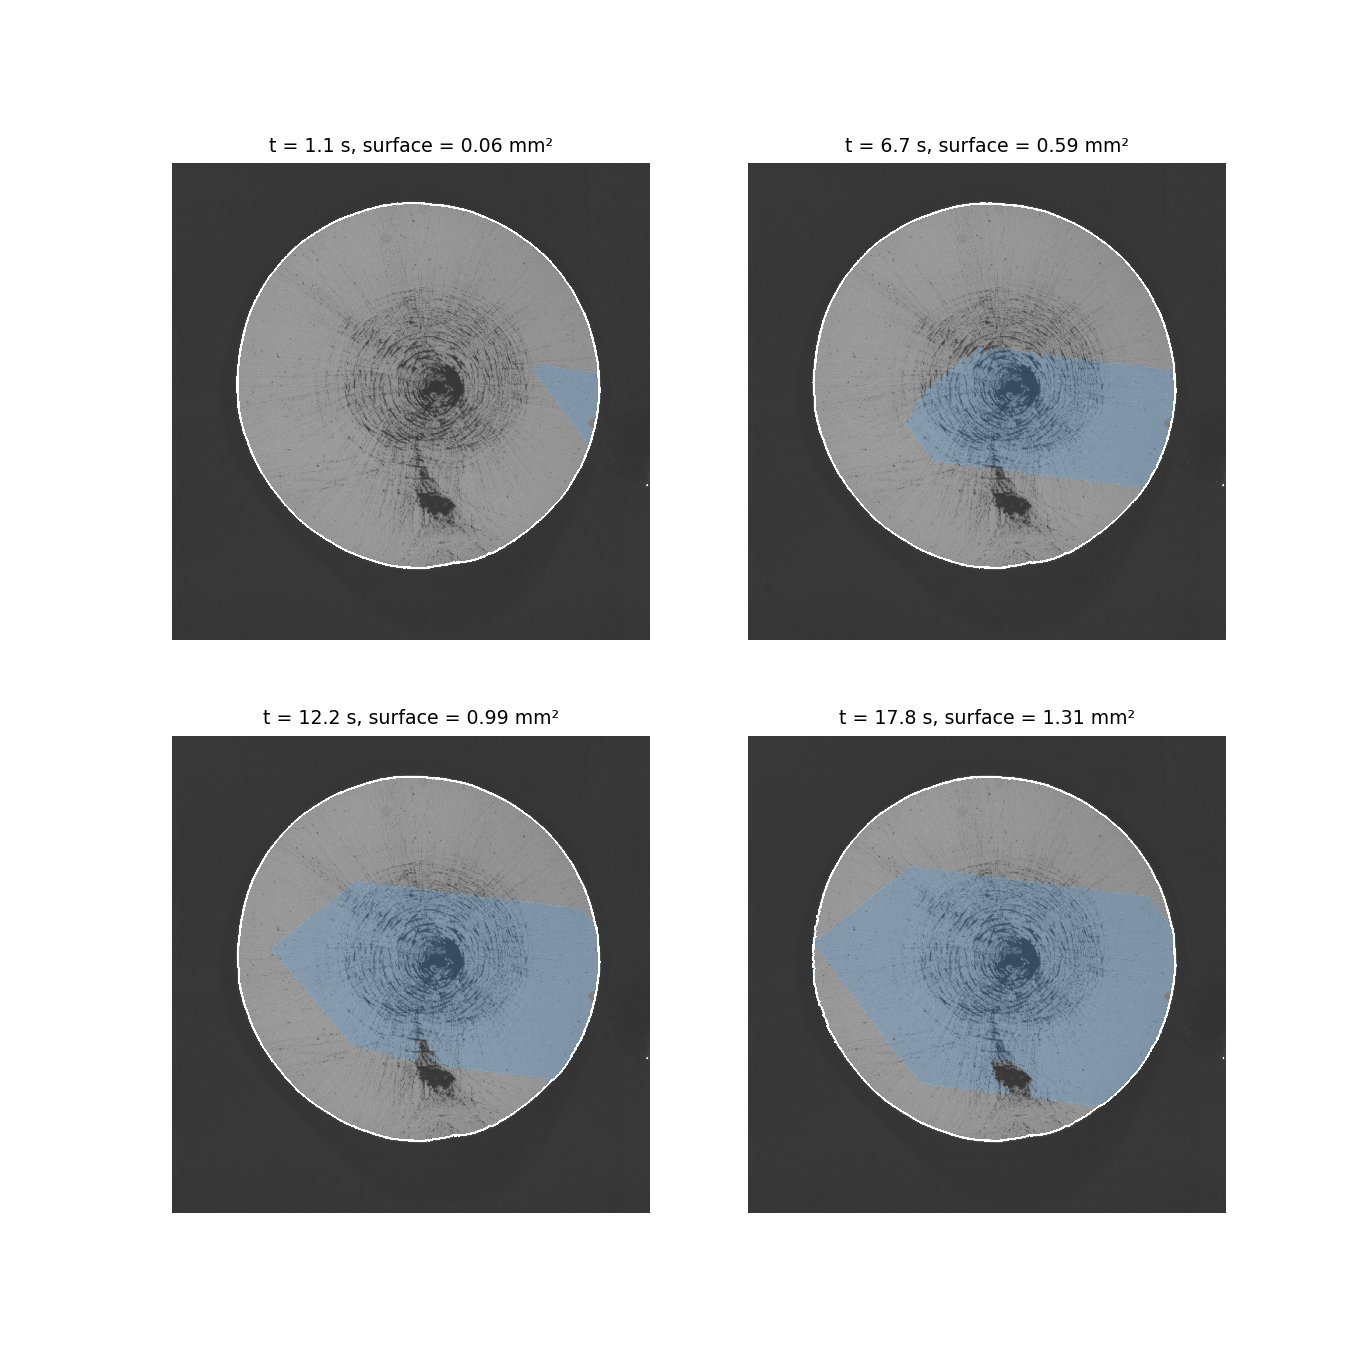

In [45]:
j = 200

plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(2,2,i + 1)
    Imout, S = contour(np.copy(vid[j]))
    plt.imshow(Imout)
    t = (j-ini)/fps
    plt.title('t = %.1f s, surface = %.2f mm²' %(t, S), fontsize = 10)
    j = j + 250

    plt.axis('off')
    

### Crystal growth

<IPython.core.display.Javascript object>


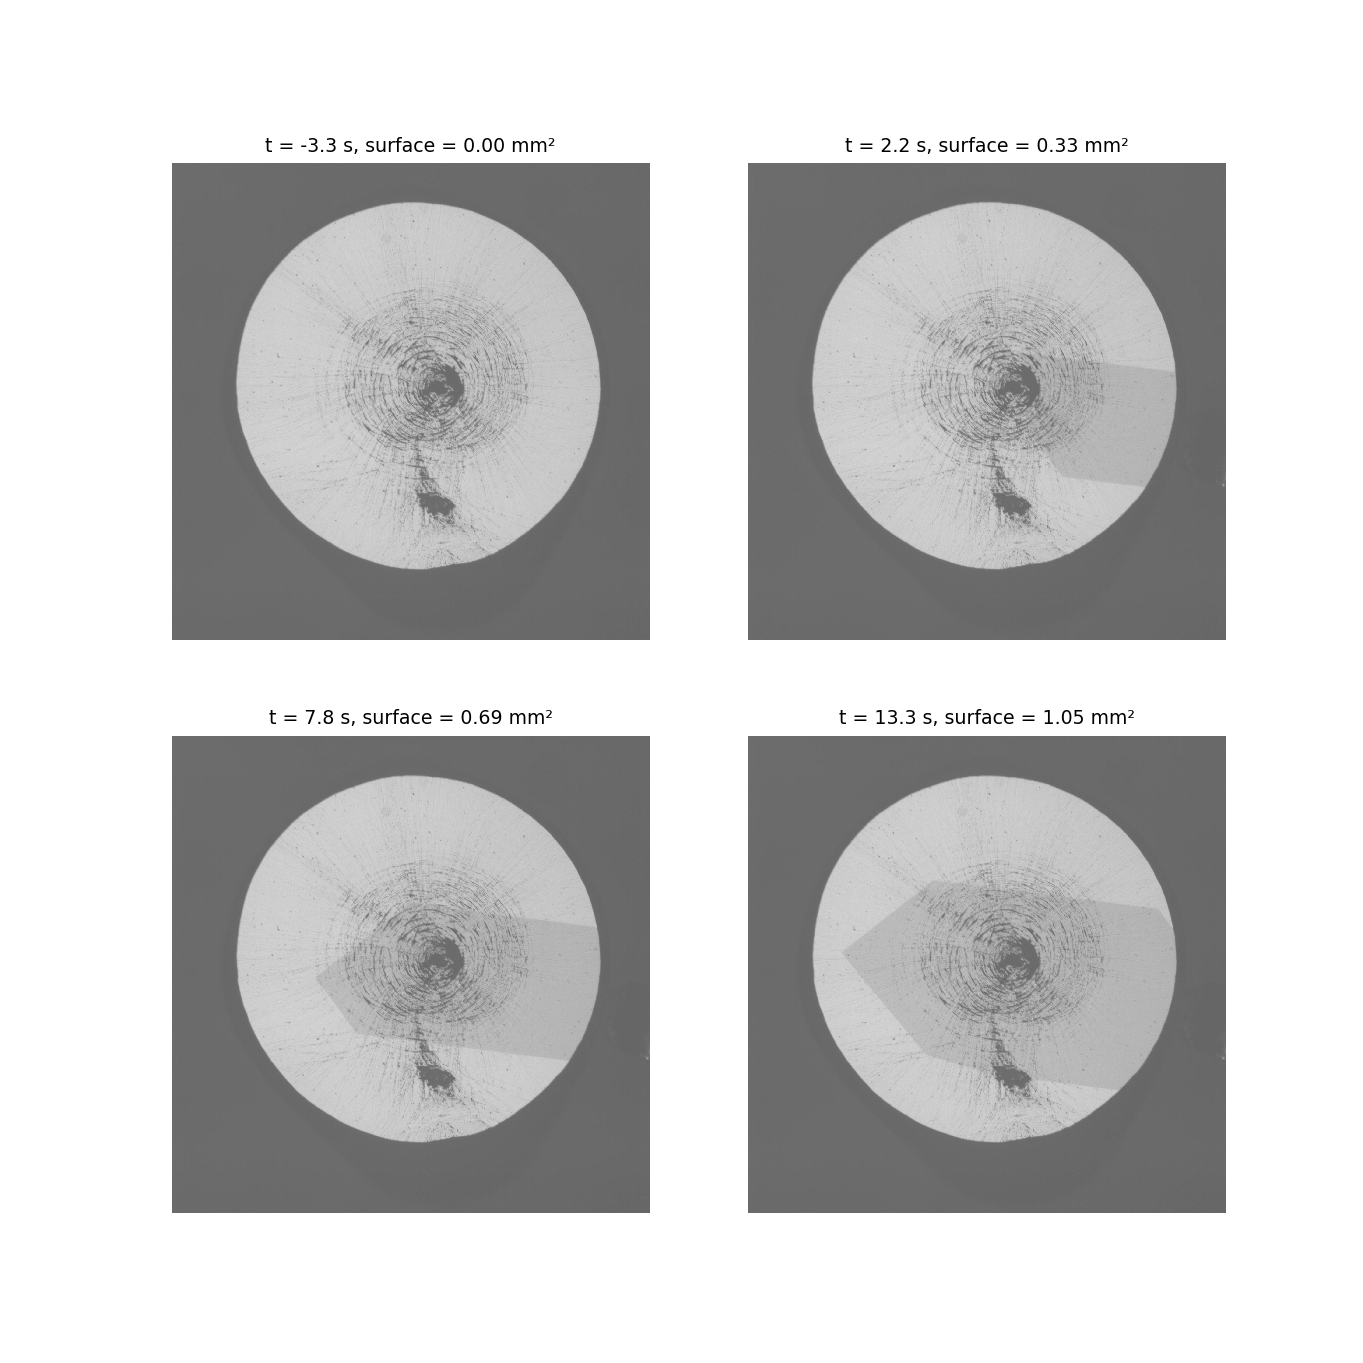

In [46]:
j = 0

plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(2,2,i + 1)
    Imout, S = contour(np.copy(vid[j]))
    plt.imshow(vid[j])
    t = (j-ini)/fps
    plt.title('t = %.1f s, surface = %.2f mm²' %(t, S), fontsize = 10)
    j = j + 250

    plt.axis('off')
    

### Save crystal growing in a video

In [71]:
save_cristal = 0 
#If set to 1, the next cell will save a video and take a long time to run
#If set to 2, the next cell will save an array with the crystal growth with time

In [72]:
if save_cristal == 1:
    outputdir = {"-c:v": "huffyuv"} 
    back = vid[ini]
    S = []
    writer = skv.FFmpegWriter("D:\Max_Planck\github_crystal_sept_12_03.avi")#, outputdict = outputdir) #video writer

    for i in range(ini + 1,N):
        im = vid[i]
        ws = extract_crystal(im, back, 20)
        S.append(np.sum(ws)/pix) #SURFACE AREA
        out = morpho.binary_fill_holes(ws)
        output = (255*np.uint8(out), 255*np.uint8(out), 255*np.uint8(out)) 
        #filt = scipy.ndimage.gaussian_filter(output, sigma=3)
        writer.writeFrame(output)
    writer.close()
    np.savetxt("Crystal_sept_12_02.csv", S, delimiter = ',')
    
    
elif save_crystal = 2:
    S = []
    back = vid[0]
    
    for i in range(1, N):
        im = vid[i]
        ws = extract_crystal(im, back, 20)
        S.append(np.sum(ws)/pix) #SURFACE AREA
        out = morpho.binary_fill_holes(ws)
        output = 255*np.uint8(out)  
        filt = scipy.ndimage.gaussian_filter(output, sigma=3)
    np.savetxt("Crystal_sept_12_02.csv", S, delimiter = ',')
    

### Surface area growth with time

In [47]:
from numpy import genfromtxt
def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

S = genfromtxt('Crystal_sept_12_02.csv', delimiter=',') #to generate from .csv file previously saved
S2 = np.copy(S)
S2 = np.concatenate((np.zeros(200),S2)) #add some zeros corresponding the the phase before crystallization
S2[1600:] = S2[1600] #smooth out the end

<IPython.core.display.Javascript object>


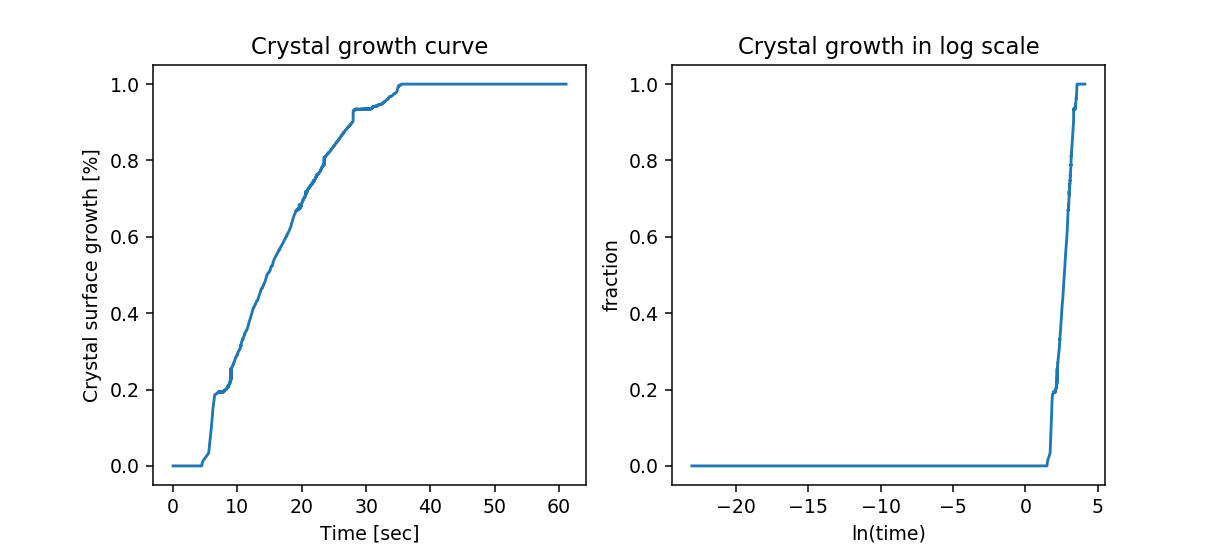

C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Text(0.5,1,'Crystal growth in log scale')

In [48]:
fr = fps
plt.figure(figsize = (9, 4))
plt.subplot(1,2,1)

d = 0
f = len(S2)
t = np.linspace(d,f, f-d)/fr
frac = S2[d:f]/(np.max(S2[d:f])+0.0001)

plt.plot(t, frac)
plt.ylabel('Crystal surface growth [%]')
plt.xlabel('Time [sec]')
plt.title('Crystal growth curve')

plt.subplot(1,2,2)

T = safe_ln(t)
Y = np.log(np.log(1/(1-frac)))

plt.plot(T, frac)
plt.ylabel('fraction')
plt.xlabel('ln(time)')
plt.title('Crystal growth in log scale')

### Linear regression

<IPython.core.display.Javascript object>


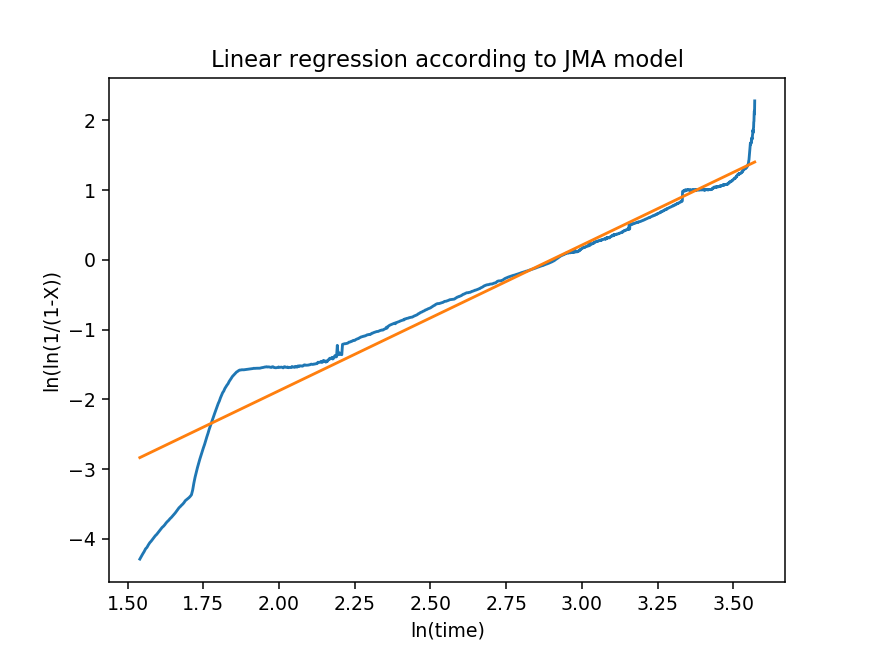

Linear regression parameters, origin = -6.046730512539111 slope = 2.086126016393551


In [49]:
def uni(X, Y):
    
    X = X-X.mean()
    Y = Y-Y.mean()
    beta = np.dot(X, Y.T)/np.dot(X, X.T)    #beta is the slope of the regression
    
    return beta

def regress(X, Y):
    b = uni(X, Y)
    a = Y.mean() - b * X.mean()
    return  b * X + a

def ab(X,Y):
    b = uni(X, Y)
    a = Y.mean() - b * X.mean()
    return  a

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

d = 210
f = 1600
frac = S2[d:f]/(np.max(S2[d:f])+0.0001)

T = safe_ln(np.linspace(d,f, f-d)/fr)
Y = safe_ln(np.log(1/(1-frac)))

b =  uni(T,Y)
a = ab(T,Y)
Yreg = regress(T, Y)

plt.figure()
plt.plot(T, Y)
plt.plot(T, Yreg )

plt.ylabel('ln(ln(1/(1-X))')
plt.xlabel('ln(time)')
plt.title('Linear regression according to JMA model')

print ('Linear regression parameters, origin =', a,'slope =', b)

### JMA model

JMA parameters, n = 2.086126016393551 k = 0.05510332711876021


<IPython.core.display.Javascript object>


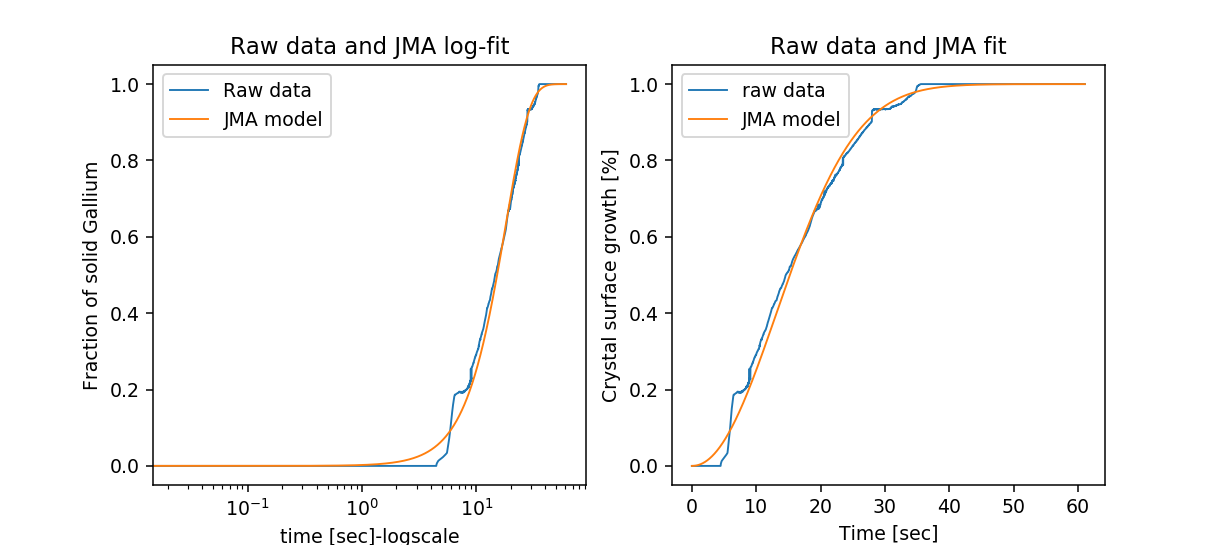

Text(0.5,0,'Time [sec]')

In [50]:
d = 0
f = len(S2)
t = np.linspace(0, f, f-d)/fr
n = b
k = np.exp(a/b) #JMA parameter
Yfit = 1-np.exp(-(t*k)**n) #JMA model

print('JMA parameters, n =', n, 'k =', k)

#Plot in logscale
plt.figure(figsize = (9, 4))

plt.subplot(1, 2, 1)
plt.semilogx(t, S2[0:f-d]/S2[-1], label = "Raw data", linewidth=1.0) 
plt.semilogx(t, Yfit, label = "JMA model", linewidth=1.0)
plt.ylabel("Fraction of solid Gallium")
plt.xlabel("time [sec]-logscale")
plt.title('Raw data and JMA log-fit')

plt.legend()

plt.subplot(1, 2,2)
regr = 1 - np.exp(-(k*t)**n)
plt.plot(t, S2[d:f]/S2[-1], label = "raw data", linewidth=1.0)
plt.plot(t, Yfit, label = "JMA model" , linewidth=1.0)
plt.ylabel('Crystal surface growth [%]')
plt.title('Raw data and JMA fit')
plt.legend()
plt.xlabel('Time [sec]')